<a href="https://colab.research.google.com/github/Andrii-Radyhin/Intenship-Description-Task-1/blob/main/notebooks/OCR_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture

#Note, it takes a while to run this cell.
!apt-get update && apt-get install -y python3-opencv
!pip install opencv-python
!pip install opendatasets
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog


#Import Relevant Libraries
import random
from PIL import Image, ImageOps
from tqdm import tqdm
import decimal
import shutil
import opendatasets as od
import os
import matplotlib.pyplot as plt
import cv2, re
import pandas as pd

%matplotlib inline

In [ ]:
#Create new directory and add model images to it.
os.mkdir('content')
os.chdir('content')

In [ ]:
%%capture

#Download processed data from Roboflow.
!curl -L "{https://app.roboflow.com/ds/jGCiAQzrvI?key=ZmR7CmNT98}" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
#Register directories for training, testing, and validation datasets.
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "train/_annotations.coco.json", "train")
register_coco_instances("my_dataset_val", {}, "valid/_annotations.coco.json", "valid")
register_coco_instances("my_dataset_test", {}, "test/_annotations.coco.json", "test")

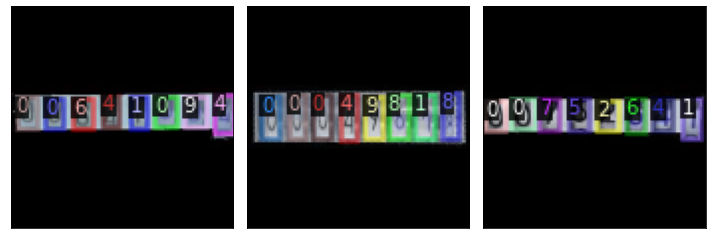

In [ ]:
#Visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

axes=[]
fig=plt.figure(figsize=(10, 10))

#View three sample training images.
for i, d in enumerate(random.sample(dataset_dicts, 3)):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
        
    #Print the resized image and dislpay the shape.
    axes.append(fig.add_subplot(1, 3, i+1))
    plt.imshow(vis.get_image()[:, :, ::-1])

#Remove ticks from each image.
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

#Plot the image.
fig.tight_layout()    
plt.show()

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

#Create trainer. 
class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
#Configure model parameters.
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  #Initialize training from model zoo.
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500 #Adjusted up as mAP was still increasing after 1500.
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 11 #classes + 1 | We are trying to detect 10 different digits (0-9). 
cfg.TEST.EVAL_PERIOD = 500

In [ ]:
#Need to clear GPU memory, as Kaggle's limits sometimes cause memory error.
from numba import cuda
cuda.select_device(0)
cuda.close()

In [ ]:
#Train model.
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

model_final_68b088.pkl: 421MB [00:08, 52.1MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.68s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.506
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.354
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.642
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.643
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

In [ ]:
#%%skip True

#Get prediction metrics for test dataset.
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85

predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.632
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.949
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.790
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.633
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.707
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.707
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

OrderedDict([('bbox',
              {'AP': 63.22074804996848,
               'AP50': 94.93685765033099,
               'AP75': 78.95841857219257,
               'APs': 63.319688944502104,
               'APm': 67.53355335533553,
               'APl': nan,
               'AP-numbers': nan,
               'AP-0': 63.870179922649285,
               'AP-1': 60.469394580760884,
               'AP-2': 69.3514599047718,
               'AP-3': 69.3518019198563,
               'AP-4': 61.17366052065499,
               'AP-5': 55.334766385056625,
               'AP-6': 68.38462959596453,
               'AP-7': 58.90045259195092,
               'AP-8': 64.8014802459201,
               'AP-9': 60.56965483209936})])

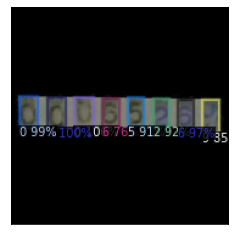

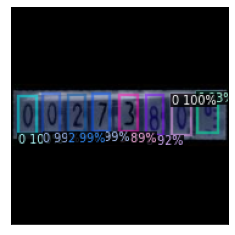

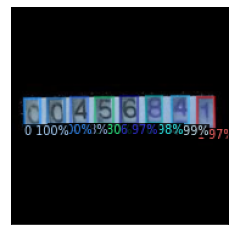

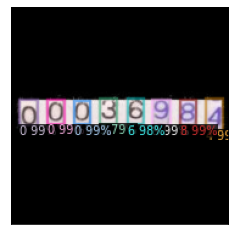

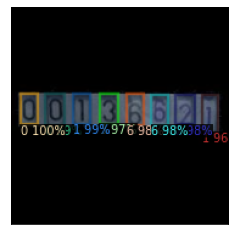

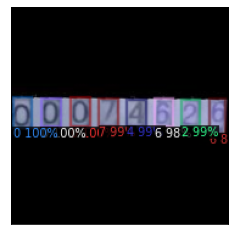

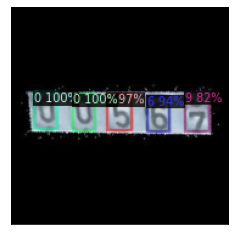

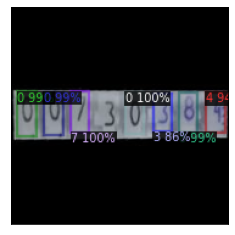

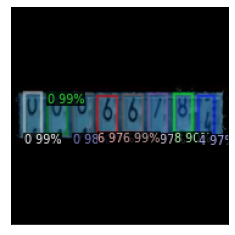

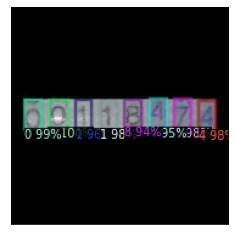

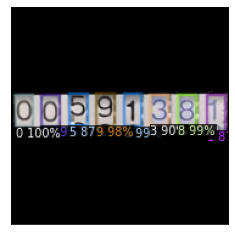

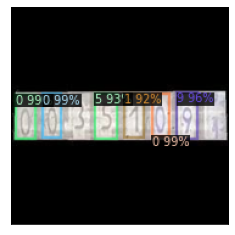

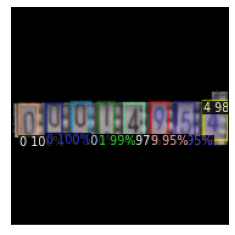

In [ ]:
import re
import pandas as pd
#Obtain model and parameters for obtaining predictions from test images.
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") <-- Changed path to saved file. 
cfg.MODEL.WEIGHTS = '/content/content/output/model_final.pth'#'../../input/water-meter-ocr-images/output/model_final.pth'
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")
#metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]) <-- Can't be used when changed saved dir.
metadata = MetadataCatalog.get("my_dataset_train")
class_catalog = metadata.thing_classes
#Import necessary libraries.
from detectron2.utils.visualizer import ColorMode
import glob

#List for storing meter readings.
list_of_img_reading = []

#Obtain test predictions.
#for i, imageName in enumerate(glob.glob('test/*jpg')): <-- Once reading from saved file, have to change.
for i, imageName in enumerate(os.listdir('/content/content/test')): #('../../input/water-meter-ocr-images/content/test')):
    #Read image and get output information.
    if 'coco' in imageName:
        pass
    else:
        #im = cv2.imread(os.path.join('../../input/water-meter-ocr-images/content/test', imageName))
        im = cv2.imread(os.path.join('/content/content/test', imageName))
        outputs = predictor(im)
    
        #Find predicted boxes and labels.
        instances = outputs['instances']
        coordinates = outputs['instances'].pred_boxes.tensor.cpu().numpy()
        pred_classes = outputs['instances'].pred_classes.cpu().tolist()
    
        #Obtain list of all predictions and the leftmost x-coordinate for bounding box.
        pred_list = []
        for pred, coord in zip(pred_classes, coordinates):
            pred_list.append((pred, coord[0]))
    
        #Sort the list based on x-coordinate in order to get proper order or meter reading.
        pred_list = sorted(pred_list, key=lambda x: x[1])
    
        #Get final order of identified classes, and map them to class value.
        final_predictions = [x[0] for x in pred_list]
        pred_class_names = list(map(lambda x: class_catalog[x], final_predictions))
    
        #Add decimal point to list of digits depending on number of bounding boxes.
        if len(pred_class_names) == 5:
            pass
        else:
            pred_class_names.insert(5, '.')
    
        #Combine digits and convert them into a float.
        combine_for_float = "".join(pred_class_names)
        meter_reading = float(combine_for_float)
    
        #Visualize prediction.  
        metadata_model = MetadataCatalog.get("mydataset")
        v = Visualizer(im[:, :, ::-1], metadata=test_metadata, scale=0.8)
    
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        parsed_name = re.findall(r"([a-zA-Z0-9]*_?[a-zA-Z0-9]*_?[a-zA-Z0-9]*_?[a-zA-Z0-9]*_?[a-zA-Z0-9]*)", imageName)
        list_of_img_reading.append((parsed_name[0], meter_reading))
    
        #Plot only subset of images.
        if i % 5 == 0:
            plt.figure()
            plt.imshow(out.get_image()[:, :, ::-1])
            plt.xticks([])
            plt.yticks([])
        else:
            pass

In [ ]:
data = pd.read_csv('/content/new_data.csv')

#Create DataFrame from predictions, and format photo name to the same style as in provided DataFrame.
df_predicted = pd.DataFrame(list_of_img_reading, columns=['photo_name', 'reading'])
df_predicted.photo_name = df_predicted['photo_name'].apply(lambda x: x + '.jpg')

#Upload provided data to DataFrame.
df_provided = data.copy()

#Create list to get info from both DataFrames where photo names overlap.
provided_and_predicted = []
pred_list = list(df_predicted['photo_name'].values)

for image_name, predicted_value in df_predicted.values:
    provided_row = df_provided[df_provided['photo_name'] == image_name]
    provided_value = float(provided_row['value'].values)
    provided_and_predicted.append((image_name, provided_value, predicted_value))
    
compiled_df = pd.DataFrame(provided_and_predicted, columns=['image_name', 'ground_truth', 'predicted_value'])
display(compiled_df.head())

,image_name,ground_truth,predicted_value
0,id_1054_value_65_26.jpg,65.260,65.269
1,id_1041_value_22_136.jpg,22.136,22.136
2,id_1045_value_122_269.jpg,122.269,122.260
3,id_1166_value_165_706.jpg,165.706,165.705
4,id_1234_value_850_0.jpg,850.000,850.000


In [ ]:
#Round each value to 3 decimal places and calculate difference between predicted value and ground truth.
compiled_df['ground_truth'] = compiled_df['ground_truth'].apply(lambda x: round(x, 3))
compiled_df['predicted_value'] = compiled_df['predicted_value'].apply(lambda x: round(x, 3))
compiled_df['difference'] = abs((compiled_df['ground_truth']) - (compiled_df['predicted_value']))

#Calculate percentage difference between ground truth and predicted value.
compiled_df['percent_diff'] = (compiled_df['difference'] / ((compiled_df['ground_truth'] + compiled_df['predicted_value']) / 2) * 100)
display(compiled_df.head())

,image_name,ground_truth,predicted_value,difference,percent_diff
0,id_1054_value_65_26.jpg,65.260,65.269,0.009,0.013790
1,id_1041_value_22_136.jpg,22.136,22.136,0.000,0.000000
2,id_1045_value_122_269.jpg,122.269,122.260,0.009,0.007361
3,id_1166_value_165_706.jpg,165.706,165.705,0.001,0.000603
4,id_1234_value_850_0.jpg,850.000,850.000,0.000,0.000000


In [ ]:
#Round each value to 3 decimal places and calculate difference between predicted value and ground truth.
compiled_df['ground_truth'] = compiled_df['ground_truth'].apply(lambda x: round(x, 3))
compiled_df['predicted_value'] = compiled_df['predicted_value'].apply(lambda x: round(x, 3))
compiled_df['difference'] = abs((compiled_df['ground_truth']) - (compiled_df['predicted_value']))

#Calculate percentage difference between ground truth and predicted value.
compiled_df['percent_diff'] = (compiled_df['difference'] / ((compiled_df['ground_truth'] + compiled_df['predicted_value']) / 2) * 100)
display(compiled_df.head())

,image_name,ground_truth,predicted_value,difference,percent_diff
0,id_1054_value_65_26.jpg,65.260,65.269,0.009,0.013790
1,id_1041_value_22_136.jpg,22.136,22.136,0.000,0.000000
2,id_1045_value_122_269.jpg,122.269,122.260,0.009,0.007361
3,id_1166_value_165_706.jpg,165.706,165.705,0.001,0.000603
4,id_1234_value_850_0.jpg,850.000,850.000,0.000,0.000000


In [ ]:
#Obtain list of percentages over 5% error and with no error.
over_5_error = [x for x in compiled_df['percent_diff'] if x >= .05]
no_error = [x for x in compiled_df['percent_diff'] if x == 0]

print(f'Total number of accurate predictions: {len(no_error)}. Percentage of total: {round(len(no_error) / len(compiled_df), 3)}')
print(f'Total number of predictions with less than 5% error: {len(compiled_df) - len(over_5_error)}. Percentage of Total: {round((len(compiled_df) - len(over_5_error)) / len(compiled_df), 3)}')
print(f'Total number of predictions with over 5% error: {len(over_5_error)}. Percentage of total: {round(len(over_5_error) / len(compiled_df), 3)}')

Total number of accurate predictions: 33. Percentage of total: 0.541
Total number of predictions with less than 5% error: 47. Percentage of Total: 0.77
Total number of predictions with over 5% error: 14. Percentage of total: 0.23
